## Import ##

In [60]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, activations
import matplotlib.pyplot as plt
from model_profiler import model_profiler
import pathlib
from pathlib import Path
import cv2 as cv
import json
import pandas as pd
import nvidia_smi
from numba import cuda

batch_size = 200
epoch_size = 3000
test_len = 8

In [61]:
def flatten(l):
    return [item for sublist in l for item in sublist]


def get_txt_data(path: Path) -> np.ndarray:
    with path.open("r", encoding="utf-8") as f:
        result: list = json.loads(f.readline())
        return np.array(flatten(result))


# p = pathlib.Path('../../openCV_python/data/out/resized_frames/resized')
# txt_files = list(p.glob('*.txt'))
# img_files = [item.parent.resolve() / item.stem for item in txt_files]
# txt_files[0].stem
# image = txt_files[0].parent.resolve() / txt_files[0].stem

# img_count = len(txt_files)
# img_shape = cv.imread(str(image)).shape

# txt_shape = get_txt_data(txt_files[0]).shape

# input_shape = (img_count, *img_shape)
# output_shape = (img_count, *txt_shape)
input_data: np.ndarray = np.load('data/train_input.npy')
output_data: np.ndarray = np.load('data/train_output.npy')
input_shape = input_data.shape[1:]
output_shape = output_data.shape[1:]
# data = []

# for i in range(len(img_files)):
#     input_data[i] = cv.imread(str(img_files[i]))
#     output_data[i] = get_txt_data(txt_files[i])

print('input shape')
print(input_shape)
print()
print('output shape')
print(output_shape)


def load_data():
    l = len(input_data)
    last = l - 1
    first = int(l-l/test_len)
    train_images = input_data[0:first]
    train_labels = output_data[0:first]

    test_images = input_data[first:last]
    test_labels = output_data[first:last]
    print('Train shape: {}'.format(train_images.shape))
    print('Test shape: {}'.format(test_images.shape))

    return (train_images, train_labels), (test_images, test_labels)


input shape
(59, 40)

output shape
(8,)


In [62]:
(train_images, train_labels), (test_images, test_labels) = load_data()


Train shape: (4812, 59, 40)
Test shape: (687, 59, 40)


In [63]:
input_shape = (59, 40)
print(np.prod(input_shape))

normalization = tf.keras.layers.Normalization(axis=None)
normalization.adapt([0,255.0])

model = models.Sequential()
model.add(layers.Input(input_shape))
model.add(normalization)
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 3, activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(1024, 'relu'))
model.add(layers.Dense(1024 * 80, 'relu'))
model.add(layers.Dense(512, 'relu'))
model.add(layers.Dense(8))

model.summary()


2360
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 59, 40)           3         
 ion)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 57, 64)            7744      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 28, 64)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 flatten_7 (Flatten)         (None, 1664)              0         
                                                                 
 dense_28 (Dense)            (None, 1024)        

In [64]:
# profile = model_profiler(model, batch_size)

# print(profile)


In [65]:
model.compile(optimizer='adam',
              loss="mae",)

history = model.fit(
    train_images, train_labels,
    epochs=epoch_size,
    batch_size=batch_size,
    validation_data=(test_images, test_labels)
)


Epoch 1/3000
25/25 [==============================] - 2s 49ms/step - loss: 243.5121 - val_loss: 146.5157
Epoch 2/3000
25/25 [==============================] - 1s 46ms/step - loss: 136.7271 - val_loss: 135.7046
Epoch 3/3000
25/25 [==============================] - 1s 41ms/step - loss: 128.7874 - val_loss: 132.3339
Epoch 4/3000
25/25 [==============================] - 1s 40ms/step - loss: 124.7252 - val_loss: 125.3989
Epoch 5/3000
25/25 [==============================] - 1s 38ms/step - loss: 121.5849 - val_loss: 121.7314
Epoch 6/3000
25/25 [==============================] - 1s 42ms/step - loss: 107.6712 - val_loss: 106.3630
Epoch 7/3000
25/25 [==============================] - 1s 42ms/step - loss: 93.3500 - val_loss: 90.7075
Epoch 8/3000
25/25 [==============================] - 1s 43ms/step - loss: 81.6168 - val_loss: 89.0355
Epoch 9/3000
25/25 [==============================] - 1s 40ms/step - loss: 79.8444 - val_loss: 70.0198
Epoch 10/3000
25/25 [==============================] - 1s 40m

In [66]:
history: dict = history.history
loss = history['loss']
val_loss = history['val_loss']
l = int(len(loss) / 10)
history['loss'] = loss[l:]
history['val_loss'] = val_loss[l:]


{'loss': [5.869822978973389, 7.016317367553711, 6.249968528747559, 5.701173305511475, 6.066084861755371, 5.4921159744262695, 8.663302421569824, 11.430789947509766, 10.43906307220459, 6.755581378936768, 6.585592269897461, 7.0836501121521, 8.497389793395996, 6.976727485656738, 7.5917816162109375, 11.321099281311035, 7.005215644836426, 6.082630634307861, 5.87835168838501, 7.724987030029297, 8.666072845458984, 7.142584800720215, 6.3355393409729, 5.39064359664917, 8.897818565368652, 8.821562767028809, 6.315695285797119, 5.870160102844238, 6.772661209106445, 5.811859607696533, 5.71695613861084, 8.261746406555176, 7.473471164703369, 7.4764814376831055, 8.305622100830078, 6.845071792602539, 7.983449459075928, 7.106473922729492, 5.57774543762207, 7.048971652984619, 6.555512428283691, 6.782107830047607, 7.7702107429504395, 6.2647833824157715, 5.52090311050415, 5.497617244720459, 6.330334186553955, 8.199434280395508, 6.04292106628418, 7.25800085067749, 7.654972076416016, 7.017143249511719, 5.7424

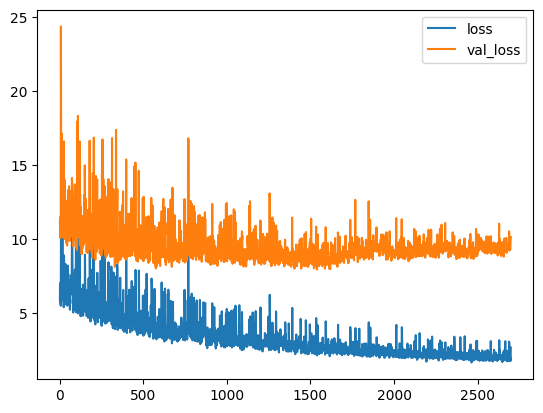

In [67]:

print(history)
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


In [68]:
# print(test_acc)

# cuda.select_device(0)
# cuda.close()


In [69]:
model.save('out')

INFO:tensorflow:Assets written to: out\assets


INFO:tensorflow:Assets written to: out\assets
